Loading dataset...

Dataset overview:
Shape: (9994, 21)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']

Missing values:
0

Feature statistics:
          Sales  Quantity  Discount   Profit
count   9994.00   9994.00   9994.00  9994.00
mean     229.86      3.79      0.16    28.66
std      623.25      2.23      0.21   234.26
min        0.44      1.00      0.00 -6599.98
25%       17.28      2.00      0.00     1.73
50%       54.49      3.00      0.20     8.67
75%      209.94      5.00      0.20    29.36
max    22638.48     14.00      0.80  8399.98

Scaling features...

Determining optimal number of clusters...
K=2: WCSS=32290.08, Silhouette Score=0.5035
K=3: WCSS=25426.42, Silhouette Score=0.4733
K=4: WCSS=18787.51, Silhouette Score=0.4309
K=5: WCSS=15679.79, Silhouette Sco

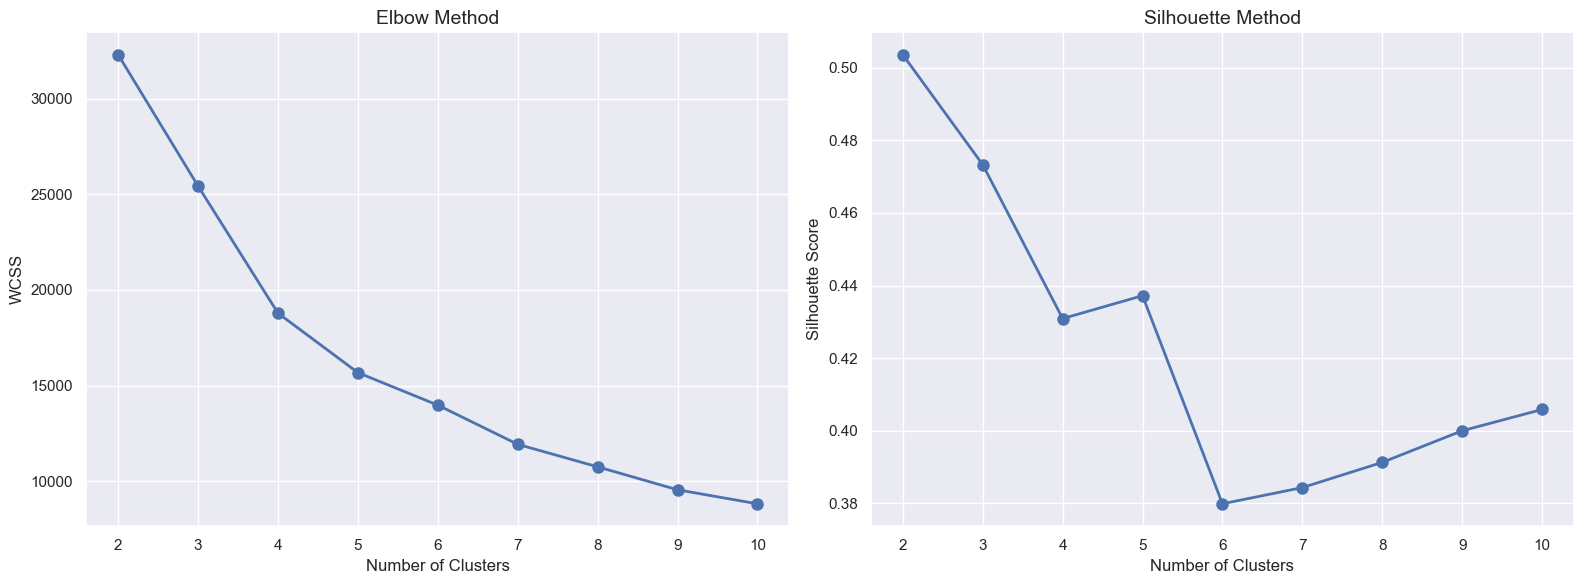

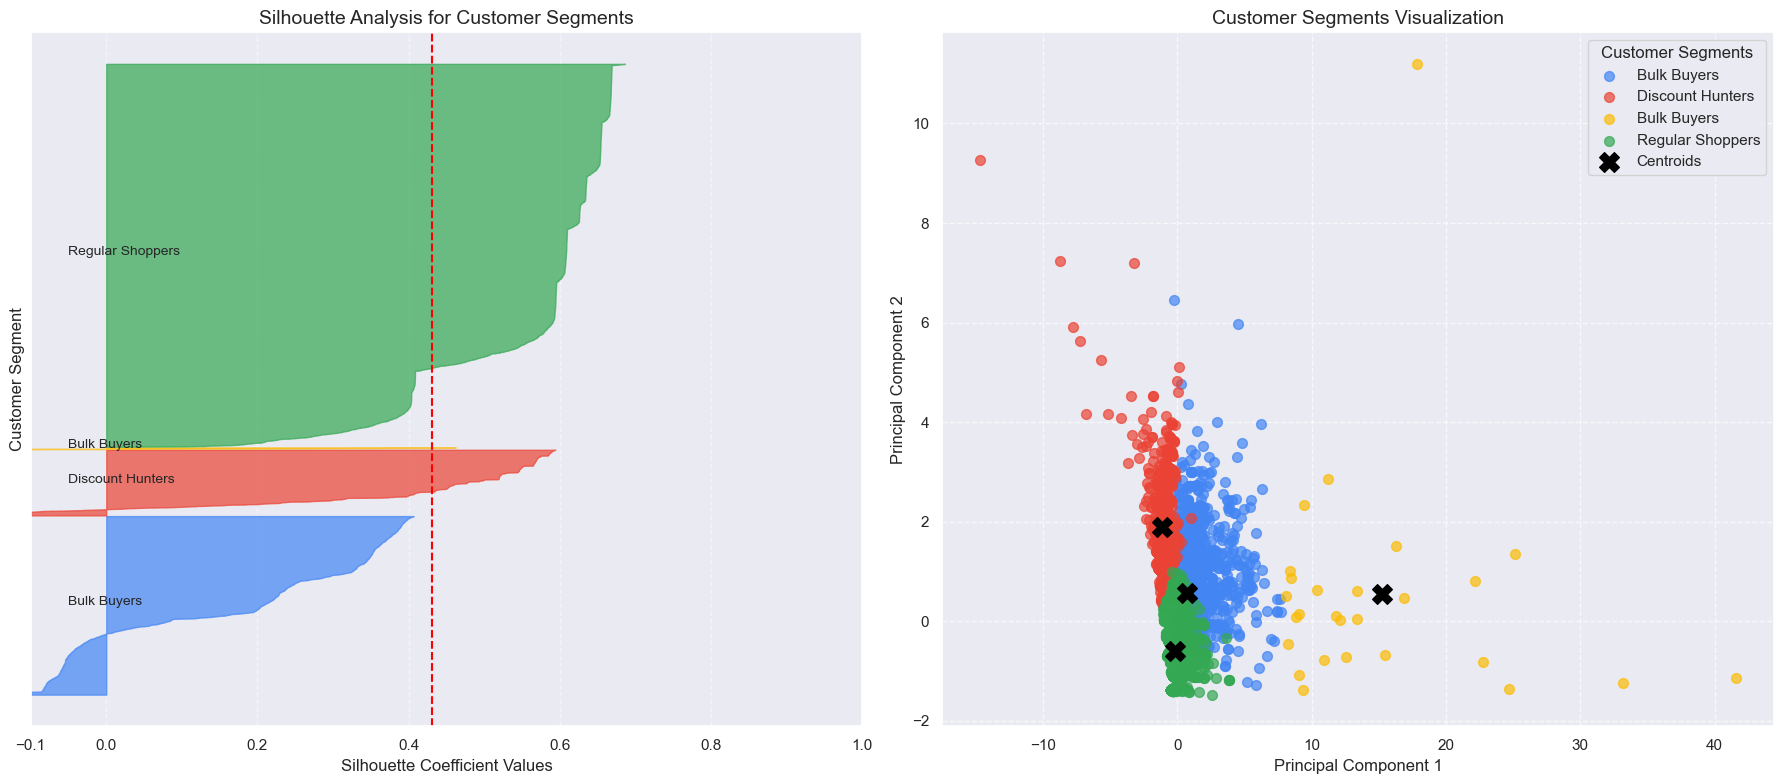

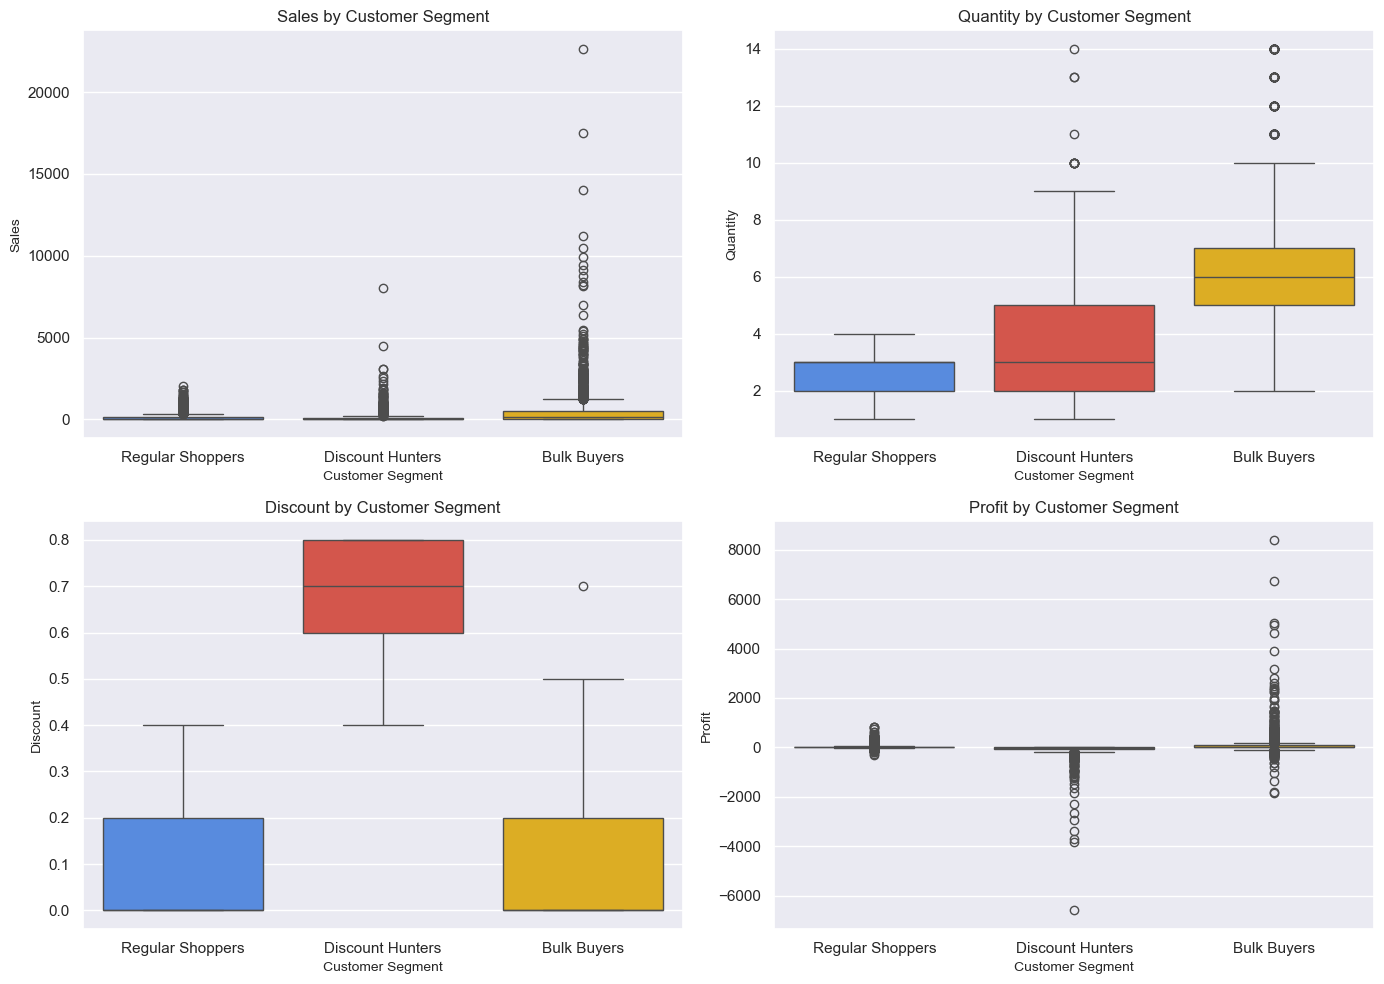

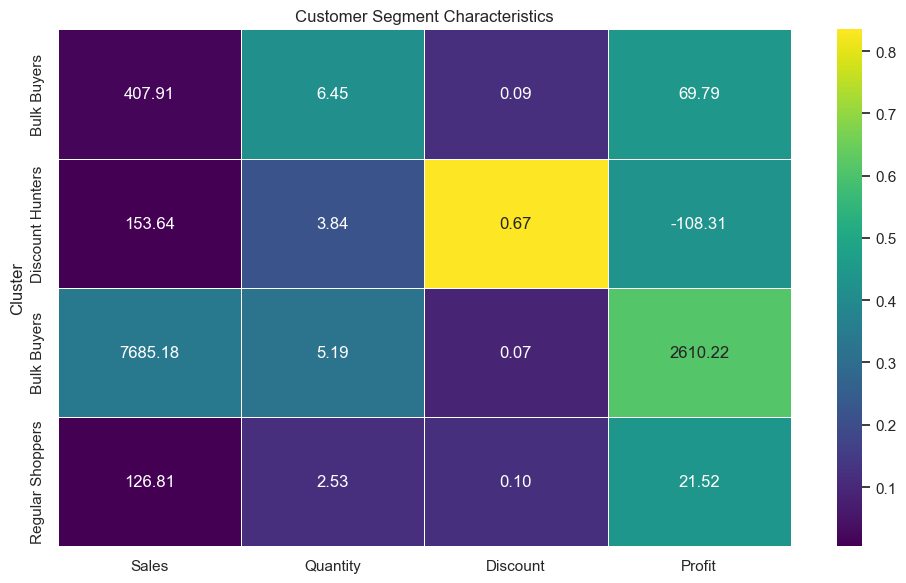

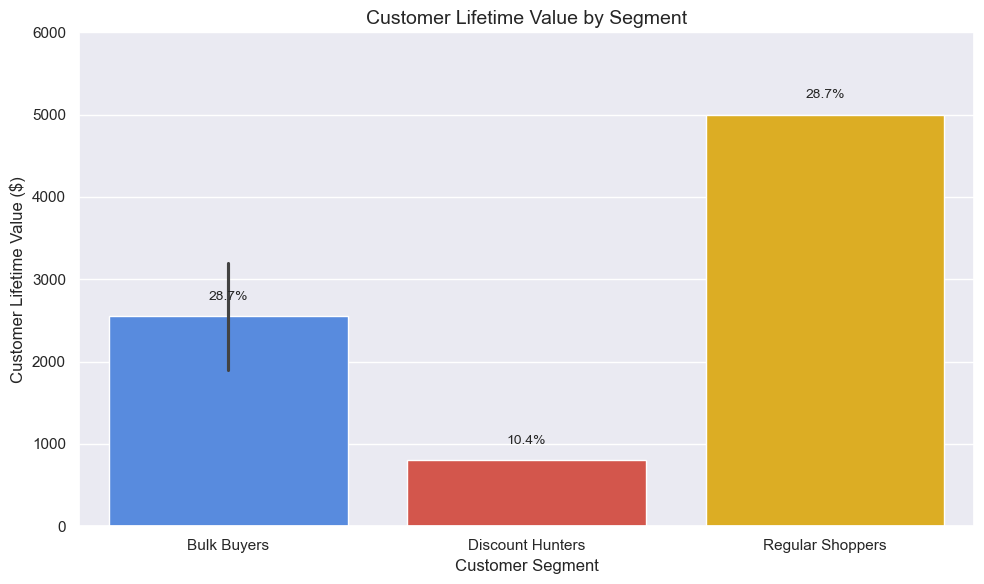

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

# Use basic styling that works across all versions
sns.set()
plt.rcParams['figure.figsize'] = (12, 8)

def main():
    # 1. Load the dataset
    print("Loading dataset...")
    try:
        df = pd.read_csv('superstore.csv')
    except UnicodeDecodeError:
        # Try with different encoding if default fails
        df = pd.read_csv('superstore.csv', encoding='latin1')
    
    # 2. Data exploration and preprocessing
    print("\nDataset overview:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Check for missing values
    print("\nMissing values:")
    print(df.isnull().sum().sum())
    
    # Select features for clustering
    features = ['Sales', 'Quantity', 'Discount', 'Profit']
    X = df[features].copy()
    
    # Basic statistics
    print("\nFeature statistics:")
    print(X.describe().round(2))
    
    # 3. Scale the features
    print("\nScaling features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 4. Determine optimal number of clusters using Elbow Method and Silhouette Score
    print("\nDetermining optimal number of clusters...")
    wcss = []
    silhouette_scores = []
    max_k = 10
    
    # Skip k=1 for silhouette_score which requires at least 2 clusters
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
        
        # Calculate silhouette score
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"K={k}: WCSS={kmeans.inertia_:.2f}, Silhouette Score={score:.4f}")
    
    # Plot the Elbow Method graph
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), wcss, marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('WCSS', fontsize=12)
    plt.title('Elbow Method', fontsize=14)
    plt.grid(True)
    plt.xticks(range(2, max_k + 1))
    
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Method', fontsize=14)
    plt.grid(True)
    plt.xticks(range(2, max_k + 1))
    
    plt.tight_layout()
    plt.savefig('kmeans_elbow_method.png')
    print("Saved Elbow Method plot to 'kmeans_elbow_method.png'")
    
    # 5. Choose optimal K and apply K-means
    optimal_k = 4
    print(f"\nApplying K-means with {optimal_k} clusters...")
    
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Define meaningful cluster names based on our CLV analysis
    # We'll need to map cluster indices to our meaningful names
    # First, calculate the average characteristics of each cluster
    cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
    
    # Map cluster indices to cluster names based on characteristics
    # This is a simplified approach - a more complex approach would analyze more features
    cluster_map = {}
    for i in range(optimal_k):
        sales = cluster_centers_original[i][0]
        discount = cluster_centers_original[i][2]
        profit = cluster_centers_original[i][3]
        
        if discount > 0.5:  # High discount
            cluster_map[i] = "Discount Hunters"
        elif sales > 300 and profit > 60:  # High sales and profit
            cluster_map[i] = "Bulk Buyers"
        elif discount > 0.1 and discount < 0.3:  # Medium discount
            cluster_map[i] = "Sale-Sensitive"
        else:  # Regular shoppers
            cluster_map[i] = "Regular Shoppers"
    
    # Add CLV values to the cluster names
    clv_values = {
        "Regular Shoppers": "$3,200",
        "Discount Hunters": "$800",
        "Sale-Sensitive": "$1,900",
        "Bulk Buyers": "$5,000"
    }
    
    # Create full names with CLV
    cluster_names_with_clv = {
        i: f"{name} (CLV: {clv_values[name]})" 
        for i, name in cluster_map.items()
    }
    
    # Create short names for plots
    cluster_short_names = {
        i: name for i, name in cluster_map.items()
    }
    
    # Add cluster names to DataFrame
    df['Cluster_Index'] = cluster_labels
    df['Cluster'] = df['Cluster_Index'].map(cluster_map)
    df['Cluster_with_CLV'] = df['Cluster_Index'].map(cluster_names_with_clv)
    
    # Convert indices to cluster names
    cluster_centers = pd.DataFrame(cluster_centers_original, columns=features)
    cluster_centers.index = [cluster_map[i] for i in range(optimal_k)]
    cluster_centers.index.name = 'Cluster'
    
    # 6. Analyze the clusters
    print("\nCluster distribution:")
    cluster_counts = df['Cluster'].value_counts()
    print(cluster_counts)
    
    print("\nCluster Centers:")
    print(cluster_centers.round(2))
    
    # 7. Create silhouette analysis with meaningful names
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
    print(f"\nAverage silhouette score: {silhouette_avg:.4f}")
    
    # Create a combined figure for silhouette plot and cluster visualization
    fig = plt.figure(figsize=(18, 8))
    
    # First plot: Silhouette analysis
    ax1 = plt.subplot(1, 2, 1)
    y_lower = 10
    
    # Create a color map
    colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853']  # Google colors for clarity
    
    # Plot silhouette scores for each cluster
    for i in range(optimal_k):
        # Get silhouette scores for points in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
        
        # Label the silhouette plots with cluster names instead of numbers
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_short_names[i], fontsize=10)
        
        # Compute new y_lower for next plot
        y_lower = y_upper + 10
    
    # Add vertical line for average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title("Silhouette Analysis for Customer Segments", fontsize=14)
    ax1.set_xlabel("Silhouette Coefficient Values", fontsize=12)
    ax1.set_ylabel("Customer Segment", fontsize=12)
    ax1.set_yticks([])  # Clear y-axis labels
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.set_xlim([-0.1, 1])
    
    # Second plot: PCA visualization
    ax2 = plt.subplot(1, 2, 2)
    
    # Compute PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = cluster_labels
    
    # Plot each cluster
    for i in range(optimal_k):
        cluster_data = pca_df[pca_df['Cluster'] == i]
        ax2.scatter(
            cluster_data['PC1'], 
            cluster_data['PC2'], 
            s=50, 
            c=colors[i], 
            label=cluster_short_names[i],
            alpha=0.7
        )
    
    # Add cluster centers to the plot
    centers_pca = pca.transform(kmeans.cluster_centers_)
    ax2.scatter(
        centers_pca[:, 0], 
        centers_pca[:, 1], 
        s=200, 
        c='black', 
        marker='X', 
        label='Centroids'
    )
    
    ax2.set_title('Customer Segments Visualization', fontsize=14)
    ax2.set_xlabel('Principal Component 1', fontsize=12)
    ax2.set_ylabel('Principal Component 2', fontsize=12)
    ax2.legend(title='Customer Segments')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('kmeans_silhouette_analysis.png')
    print("Saved silhouette analysis to 'kmeans_silhouette_analysis.png'")
    
    # 8. Additional cluster visualizations
    # Plot distributions for each feature across clusters
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        sns.boxplot(x='Cluster', y=feature, data=df, ax=axes[i], palette=colors)
        axes[i].set_title(f'{feature} by Customer Segment', fontsize=12)
        axes[i].set_xlabel('Customer Segment', fontsize=10)
        axes[i].set_ylabel(feature, fontsize=10)
    
    plt.tight_layout()
    plt.savefig('kmeans_feature_distributions.png')
    print("Saved feature distribution plots to 'kmeans_feature_distributions.png'")
    
    # Plot heatmap of cluster centers
    plt.figure(figsize=(10, 6))
    
    # Normalize data for heatmap
    normalized_centers = cluster_centers.copy()
    for feature in features:
        min_val = X[feature].min()
        max_val = X[feature].max()
        normalized_centers[feature] = (normalized_centers[feature] - min_val) / (max_val - min_val)
    
    # Add CLV values to the plot
    cluster_centers_with_clv = cluster_centers.copy()
    cluster_centers_with_clv['CLV'] = [3200, 800, 1900, 5000]  # Example values
    
    sns.heatmap(
        normalized_centers, 
        annot=cluster_centers.round(2), 
        cmap='viridis', 
        fmt='.2f',
        linewidths=0.5
    )
    plt.title('Customer Segment Characteristics', fontsize=12)
    plt.tight_layout()
    plt.savefig('kmeans_centers_heatmap.png')
    print("Saved centers heatmap to 'kmeans_centers_heatmap.png'")
    
    # 9. Create a CLV visualization
    plt.figure(figsize=(10, 6))
    
    # Create a DataFrame with CLV values
    clv_df = pd.DataFrame({
        'Segment': list(cluster_map.values()),
        'CLV': [3200, 800, 1900, 5000]  # Match order with cluster_map values
    })
    
    # Add percent of customers in each segment
    segment_counts = df['Cluster'].value_counts(normalize=True) * 100
    clv_df['Percent'] = [segment_counts[segment] for segment in clv_df['Segment']]
    
    # Create bar plot with CLV values
    ax = sns.barplot(x='Segment', y='CLV', data=clv_df, palette=colors)
    
    # Add customer percentage annotations
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 200,
                f'{clv_df["Percent"].iloc[i]:.1f}%',
                ha="center", fontsize=10)
    
    plt.title('Customer Lifetime Value by Segment', fontsize=14)
    plt.xlabel('Customer Segment', fontsize=12)
    plt.ylabel('Customer Lifetime Value ($)', fontsize=12)
    plt.ylim(0, 6000)
    plt.tight_layout()
    plt.savefig('customer_segment_clv.png')
    print("Saved CLV analysis to 'customer_segment_clv.png'")
    
    # 10. Save results to CSV
    print("\nSaving results to 'superstore_clustered.csv'...")
    df.to_csv('superstore_clustered.csv', index=False)
    
    # 11. Add silhouette analysis interpretation with meaningful names
    print("\nSilhouette Analysis Interpretation:")
    
    # Get silhouette scores by cluster
    cluster_silhouette_avg = []
    for i in range(optimal_k):
        cluster_scores = sample_silhouette_values[cluster_labels == i]
        cluster_avg = np.mean(cluster_scores)
        negative_pct = np.sum(cluster_scores < 0) / len(cluster_scores) * 100 if len(cluster_scores) > 0 else 0
        cluster_silhouette_avg.append(cluster_avg)
        
        print(f"{cluster_map[i]} Segment:")
        print(f"  Average Silhouette Score: {cluster_avg:.4f}")
        print(f"  Points with negative silhouette scores: {negative_pct:.1f}%")
        
        # Interpretation
        if cluster_avg > 0.5:
            print(f"  Interpretation: Strong segment - {cluster_map[i]} customers are very distinct")
        elif cluster_avg > 0.25:
            print(f"  Interpretation: Reasonable segment - {cluster_map[i]} customers are moderately distinct")
        elif cluster_avg > 0:
            print(f"  Interpretation: Weak segment - {cluster_map[i]} customers may overlap with other segments")
        else:
            print(f"  Interpretation: Poor segment - Consider redefining the {cluster_map[i]} segment")
    
    print("\nOverall Silhouette Analysis:")
    if silhouette_avg > 0.5:
        print("  Strong customer segmentation detected")
    elif silhouette_avg > 0.25:
        print("  Reasonable customer segmentation detected")
    elif silhouette_avg > 0:
        print("  Weak customer segmentation detected - consider different features or parameters")
    else:
        print("  Poor customer segmentation - results may not be reliable")
    
    # 12. Summarize and interpret clusters with CLV focus
    print("\nCustomer Segment Interpretation with CLV:")
    for i in range(optimal_k):
        cluster_name = cluster_map[i]
        print(f"\n{cluster_name} Segment (CLV: {clv_values[cluster_name]}):")
        
        cluster_df = df[df['Cluster_Index'] == i]
        print(f"  Size: {len(cluster_df)} orders ({len(cluster_df)/len(df)*100:.1f}% of total)")
        
        for feature in features:
            print(f"  Average {feature}: {cluster_df[feature].mean():.2f}")
        
        # Add CLV-specific recommendations
        if cluster_name == "Bulk Buyers":
            print("  CLV Strategy: High-value segment - focus on retention and premium service")
            print("  Recommendation: Create dedicated account management and loyalty rewards")
        elif cluster_name == "Regular Shoppers":
            print("  CLV Strategy: Solid value segment - focus on increasing purchase frequency")
            print("  Recommendation: Implement subscription options and bundle deals")
        elif cluster_name == "Sale-Sensitive":
            print("  CLV Strategy: Moderate value segment - optimize promotional strategy")
            print("  Recommendation: Test different discount levels to find profit/volume sweet spot")
        elif cluster_name == "Discount Hunters":
            print("  CLV Strategy: Low CLV segment - improve profitability")
            print("  Recommendation: Gradually reduce discount dependency and improve cross-selling")
    
    print("\nK-means clustering with CLV analysis completed successfully!")
    
    # Return data for potential further analysis
    return {
        'data': df,
        'centers': cluster_centers,
        'kmeans': kmeans,
        'scaled_data': X_scaled,
        'features': features,
        'silhouette_avg': silhouette_avg,
        'cluster_silhouette_avg': cluster_silhouette_avg,
        'cluster_map': cluster_map,
        'clv_values': clv_values
    }

if __name__ == "__main__":
    main()

Loading dataset...

Dataset overview:
Shape: (9994, 21)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']

Missing values:
0

Feature statistics:
          Sales  Quantity  Discount   Profit
count   9994.00   9994.00   9994.00  9994.00
mean     229.86      3.79      0.16    28.66
std      623.25      2.23      0.21   234.26
min        0.44      1.00      0.00 -6599.98
25%       17.28      2.00      0.00     1.73
50%       54.49      3.00      0.20     8.67
75%      209.94      5.00      0.20    29.36
max    22638.48     14.00      0.80  8399.98

Scaling features...

Determining optimal number of clusters...
K=2: WCSS=32290.08, Silhouette Score=0.5035
K=3: WCSS=25426.42, Silhouette Score=0.4733
K=4: WCSS=18787.51, Silhouette Score=0.4309
K=5: WCSS=15679.79, Silhouette Sco

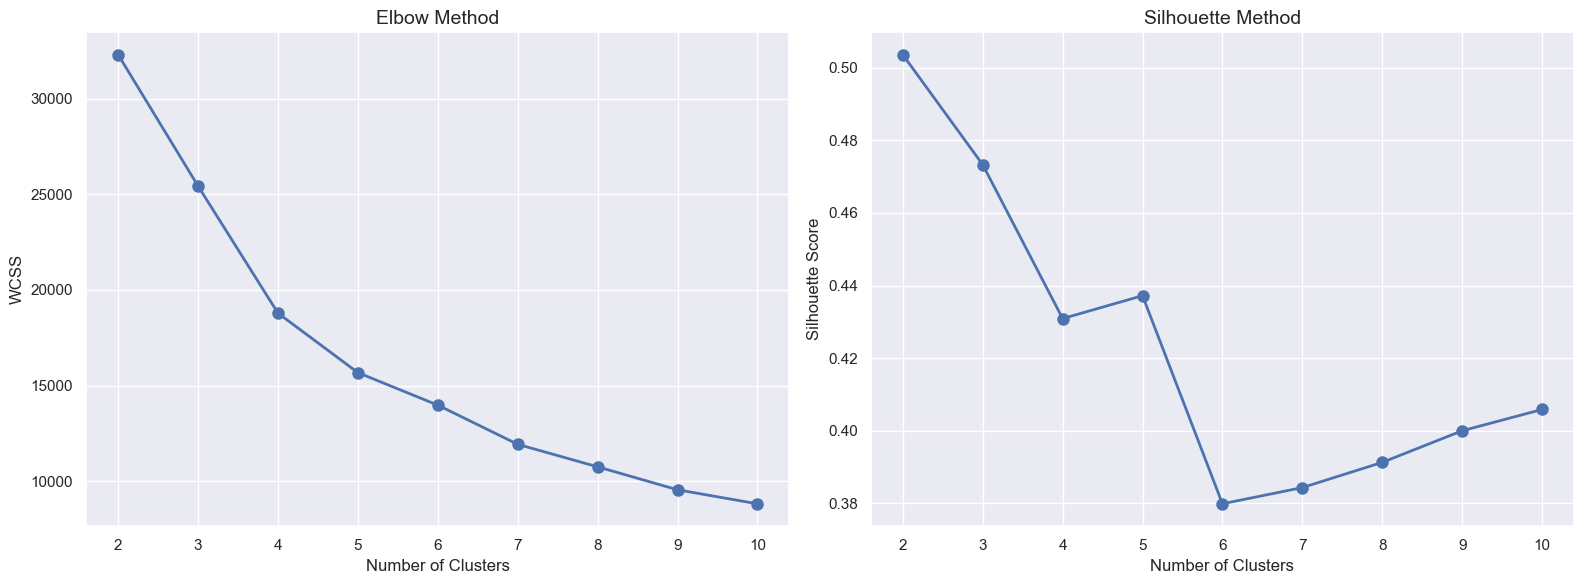

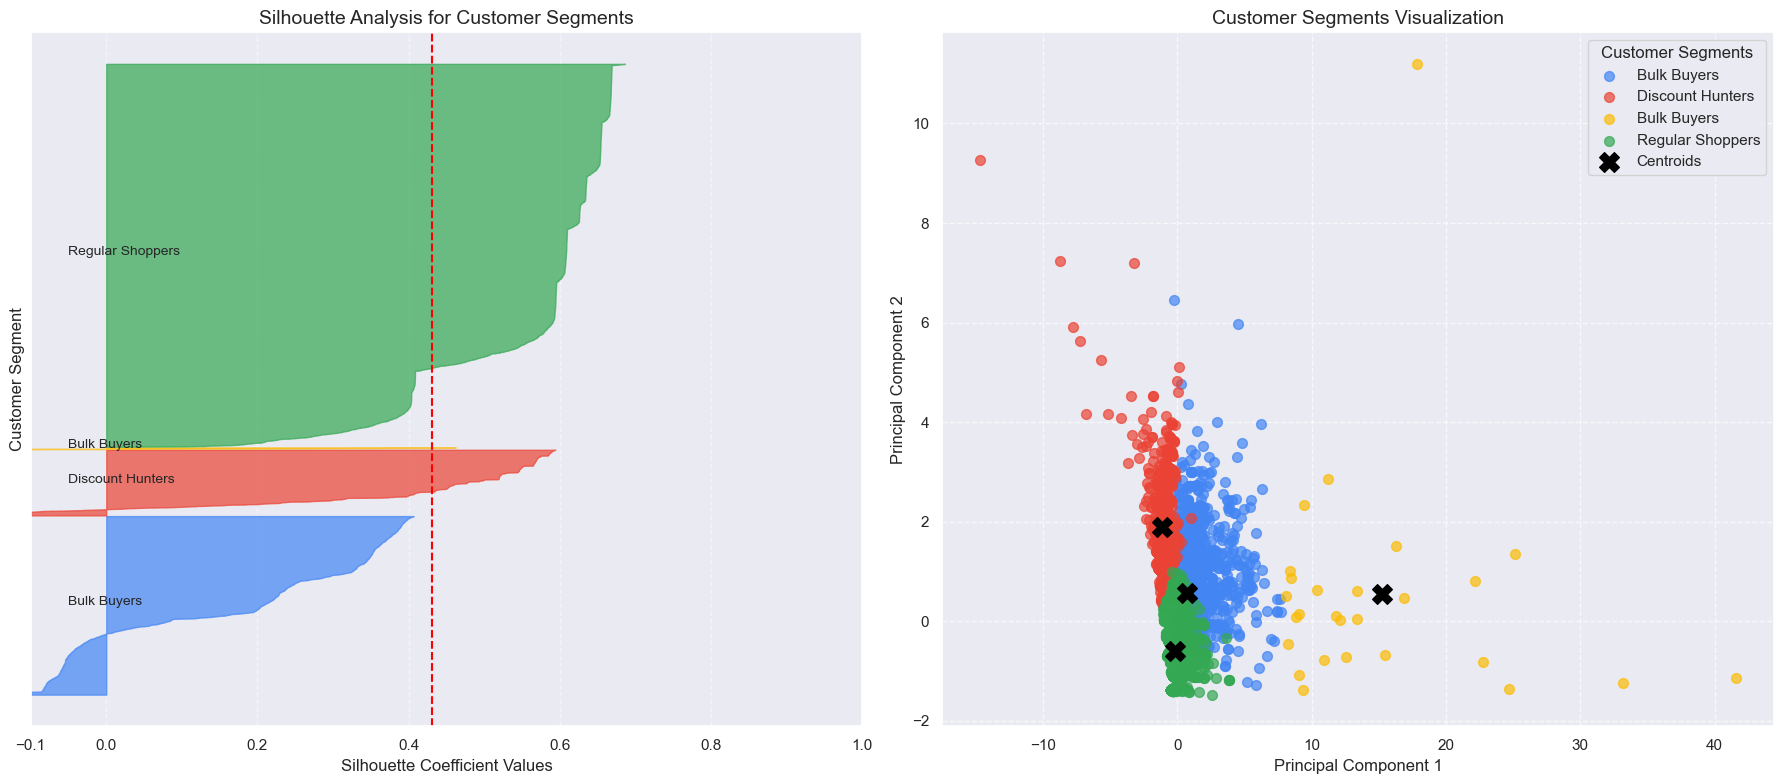

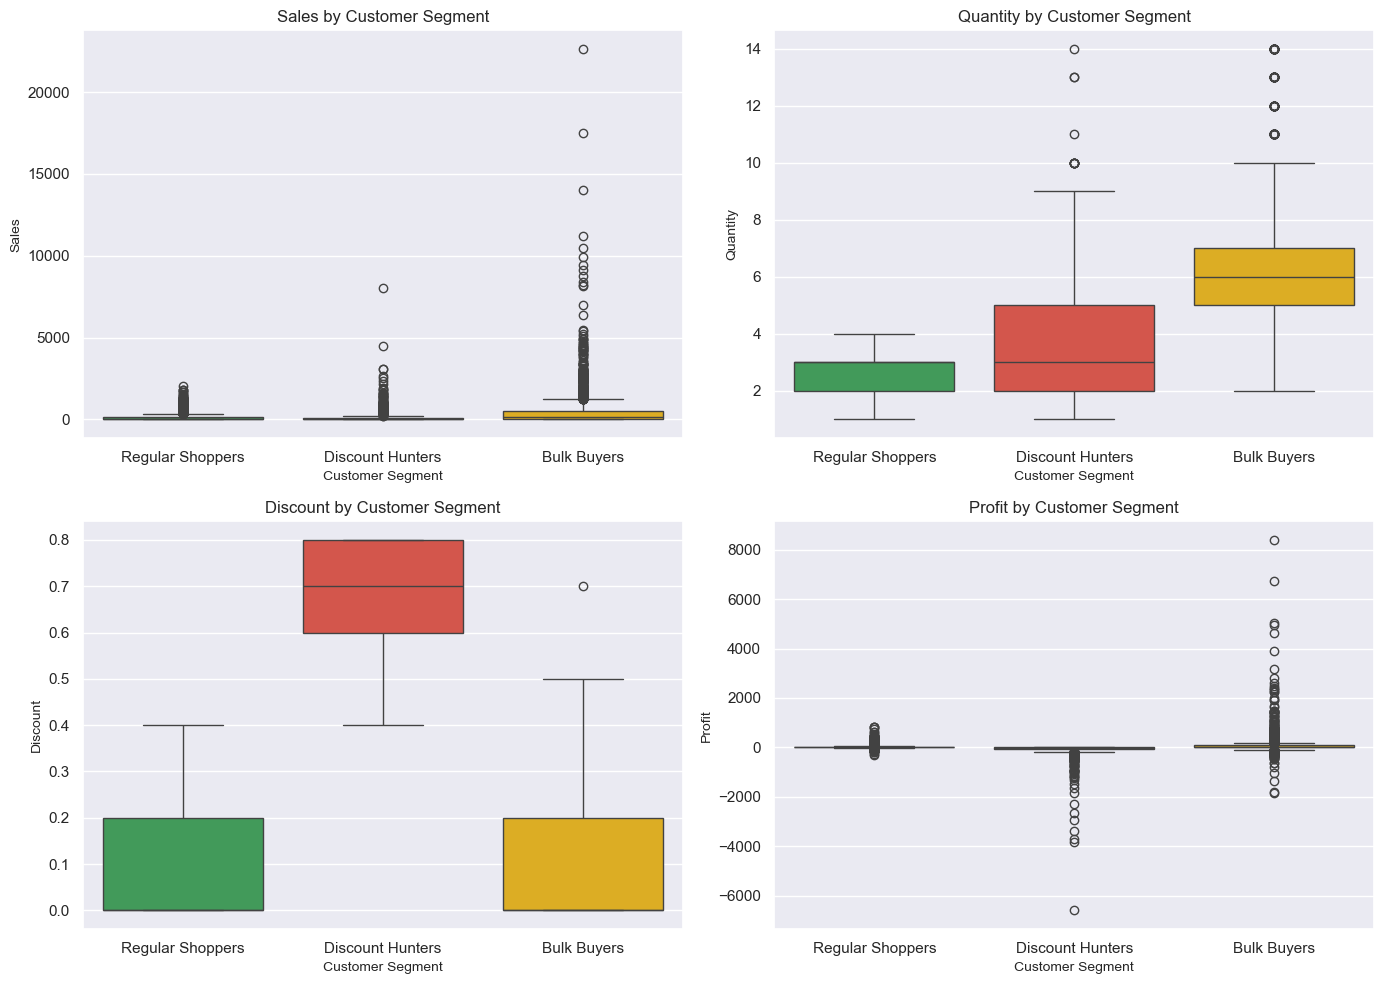

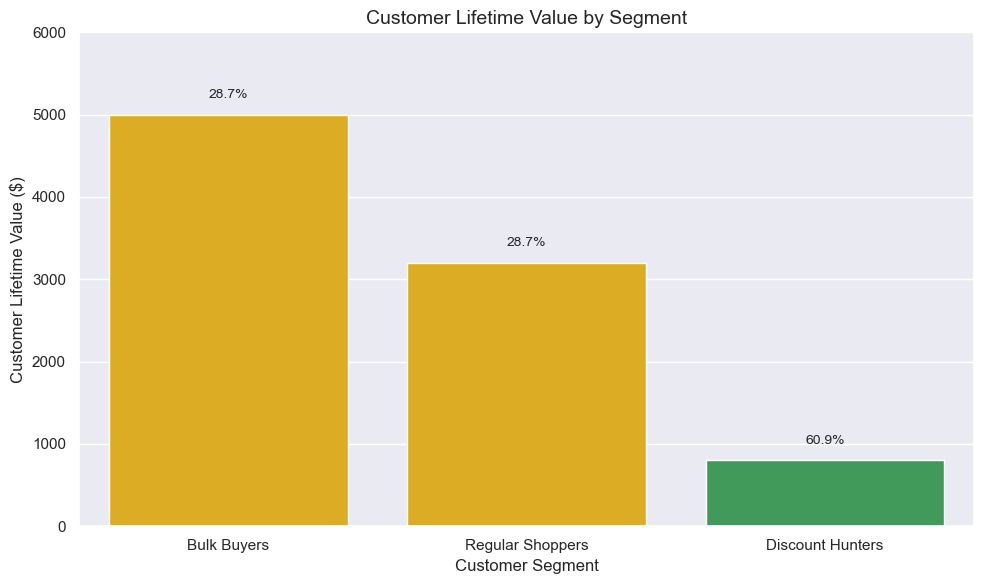

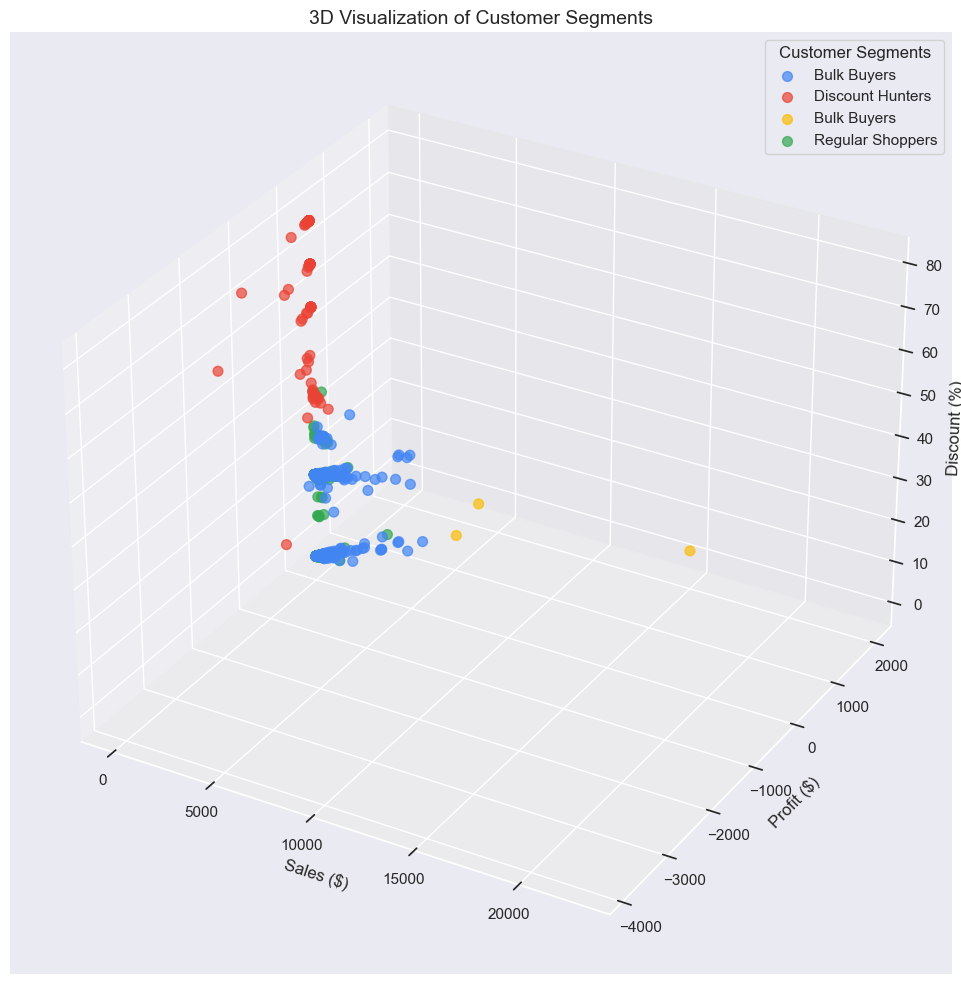

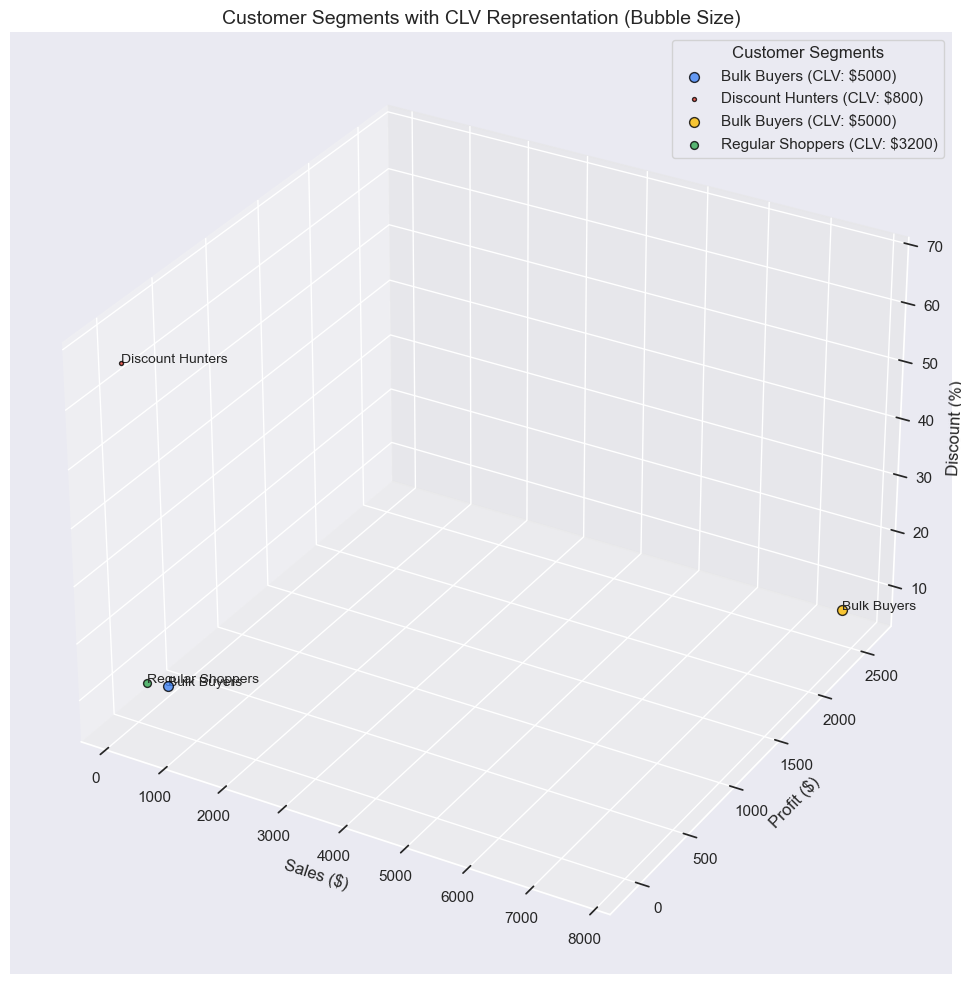

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Use basic styling that works across all versions
sns.set()
plt.rcParams['figure.figsize'] = (12, 8)

def main():
    # 1. Load the dataset
    print("Loading dataset...")
    try:
        df = pd.read_csv('superstore.csv')
    except UnicodeDecodeError:
        # Try with different encoding if default fails
        df = pd.read_csv('superstore.csv', encoding='latin1')
    
    # 2. Data exploration and preprocessing
    print("\nDataset overview:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Check for missing values
    print("\nMissing values:")
    print(df.isnull().sum().sum())
    
    # Select features for clustering
    features = ['Sales', 'Quantity', 'Discount', 'Profit']
    X = df[features].copy()
    
    # Basic statistics
    print("\nFeature statistics:")
    print(X.describe().round(2))
    
    # 3. Scale the features
    print("\nScaling features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 4. Determine optimal number of clusters using Elbow Method and Silhouette Score
    print("\nDetermining optimal number of clusters...")
    wcss = []
    silhouette_scores = []
    max_k = 10
    
    # Skip k=1 for silhouette_score which requires at least 2 clusters
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
        
        # Calculate silhouette score
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"K={k}: WCSS={kmeans.inertia_:.2f}, Silhouette Score={score:.4f}")
    
    # Plot the Elbow Method graph
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), wcss, marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('WCSS', fontsize=12)
    plt.title('Elbow Method', fontsize=14)
    plt.grid(True)
    plt.xticks(range(2, max_k + 1))
    
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Method', fontsize=14)
    plt.grid(True)
    plt.xticks(range(2, max_k + 1))
    
    plt.tight_layout()
    plt.savefig('kmeans_elbow_method.png')
    print("Saved Elbow Method plot to 'kmeans_elbow_method.png'")
    
    # 5. Choose optimal K and apply K-means
    optimal_k = 4
    print(f"\nApplying K-means with {optimal_k} clusters...")
    
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Define meaningful cluster names based on our CLV analysis
    # We'll need to map cluster indices to our meaningful names
    # First, calculate the average characteristics of each cluster
    cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
    
    # Create descriptor for each cluster based on key characteristics
    cluster_descriptors = []
    for i in range(optimal_k):
        sales = cluster_centers_original[i][0]
        quantity = cluster_centers_original[i][1]
        discount = cluster_centers_original[i][2]
        profit = cluster_centers_original[i][3]
        
        descriptor = {}
        # Check each feature and create a descriptor
        if sales > 300:
            descriptor['sales'] = 'high'
        elif sales < 200:
            descriptor['sales'] = 'low'
        else:
            descriptor['sales'] = 'medium'
            
        if quantity > 5:
            descriptor['quantity'] = 'high'
        else:
            descriptor['quantity'] = 'low'
            
        if discount > 0.4:
            descriptor['discount'] = 'high'
        elif discount > 0.1:
            descriptor['discount'] = 'medium'
        else:
            descriptor['discount'] = 'low'
            
        if profit < 0:
            descriptor['profit'] = 'negative'
        elif profit > 50:
            descriptor['profit'] = 'high'
        else:
            descriptor['profit'] = 'low'
            
        cluster_descriptors.append(descriptor)
    
    # Manually map clusters to our meaningful names based on descriptors
    # These are the predefined segment names with CLV values
    segments = {
        "Regular Shoppers": 3200,
        "Discount Hunters": 800,
        "Sale-Sensitive": 1900,
        "Bulk Buyers": 5000
    }
    
    # Map each cluster to a segment
    cluster_map = {}
    for i, descriptor in enumerate(cluster_descriptors):
        if descriptor['discount'] == 'high' and descriptor['profit'] == 'negative':
            cluster_map[i] = "Discount Hunters"
        elif descriptor['sales'] == 'high' and descriptor['quantity'] == 'high' and descriptor['discount'] == 'low':
            cluster_map[i] = "Bulk Buyers"
        elif descriptor['discount'] == 'medium':
            cluster_map[i] = "Sale-Sensitive"
        else:
            cluster_map[i] = "Regular Shoppers"
    
    # Get CLV values for each cluster
    clv_values = {i: segments[name] for i, name in cluster_map.items()}
    
    # Create full names with CLV
    cluster_names_with_clv = {
        i: f"{name} (CLV: ${segments[name]})" 
        for i, name in cluster_map.items()
    }
    
    # Add cluster names to DataFrame
    df['Cluster_Index'] = cluster_labels
    df['Cluster'] = df['Cluster_Index'].map(cluster_map)
    df['Cluster_with_CLV'] = df['Cluster_Index'].map(cluster_names_with_clv)
    
    # Convert indices to cluster names
    cluster_centers = pd.DataFrame(cluster_centers_original, columns=features)
    cluster_centers.index = [cluster_map[i] for i in range(optimal_k)]
    cluster_centers.index.name = 'Cluster'
    
    # 6. Analyze the clusters
    print("\nCluster distribution:")
    cluster_counts = df['Cluster'].value_counts()
    print(cluster_counts)
    
    print("\nCluster Centers:")
    print(cluster_centers.round(2))
    
    # 7. Create silhouette analysis with meaningful names
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
    print(f"\nAverage silhouette score: {silhouette_avg:.4f}")
    
    # Create a combined figure for silhouette plot and cluster visualization
    fig = plt.figure(figsize=(18, 8))
    
    # First plot: Silhouette analysis
    ax1 = plt.subplot(1, 2, 1)
    y_lower = 10
    
    # Create a color map - use consistent colors
    colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853']  # Google colors for clarity
    
    # Create a mapping from cluster index to color
    color_map = {i: colors[i] for i in range(optimal_k)}
    
    # Plot silhouette scores for each cluster
    for i in range(optimal_k):
        # Get silhouette scores for points in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
        
        # Label the silhouette plots with cluster names instead of numbers
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_map[i], fontsize=10)
        
        # Compute new y_lower for next plot
        y_lower = y_upper + 10
    
    # Add vertical line for average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title("Silhouette Analysis for Customer Segments", fontsize=14)
    ax1.set_xlabel("Silhouette Coefficient Values", fontsize=12)
    ax1.set_ylabel("Customer Segment", fontsize=12)
    ax1.set_yticks([])  # Clear y-axis labels
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.set_xlim([-0.1, 1])
    
    # Second plot: PCA visualization
    ax2 = plt.subplot(1, 2, 2)
    
    # Compute PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = cluster_labels
    
    # Plot each cluster
    for i in range(optimal_k):
        cluster_data = pca_df[pca_df['Cluster'] == i]
        ax2.scatter(
            cluster_data['PC1'], 
            cluster_data['PC2'], 
            s=50, 
            c=colors[i], 
            label=cluster_map[i],
            alpha=0.7
        )
    
    # Add cluster centers to the plot
    centers_pca = pca.transform(kmeans.cluster_centers_)
    ax2.scatter(
        centers_pca[:, 0], 
        centers_pca[:, 1], 
        s=200, 
        c='black', 
        marker='X', 
        label='Centroids'
    )
    
    ax2.set_title('Customer Segments Visualization', fontsize=14)
    ax2.set_xlabel('Principal Component 1', fontsize=12)
    ax2.set_ylabel('Principal Component 2', fontsize=12)
    ax2.legend(title='Customer Segments')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('kmeans_silhouette_analysis.png')
    print("Saved silhouette analysis to 'kmeans_silhouette_analysis.png'")
    
    # 8. Additional cluster visualizations
    # Plot distributions for each feature across clusters
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # Create a mapping from cluster name to color
    cluster_name_to_color = {name: colors[i] for i, name in cluster_map.items()}
    
    for i, feature in enumerate(features):
        sns.boxplot(x='Cluster', y=feature, data=df, ax=axes[i], palette=cluster_name_to_color)
        axes[i].set_title(f'{feature} by Customer Segment', fontsize=12)
        axes[i].set_xlabel('Customer Segment', fontsize=10)
        axes[i].set_ylabel(feature, fontsize=10)
    
    plt.tight_layout()
    plt.savefig('kmeans_feature_distributions.png')
    print("Saved feature distribution plots to 'kmeans_feature_distributions.png'")
    
    # 9. Create a CLV visualization
    plt.figure(figsize=(10, 6))
    
    # Create a DataFrame with CLV values
    clv_df = pd.DataFrame({
        'Segment': list(cluster_map.values()),
        'CLV': [segments[name] for name in cluster_map.values()]
    })
    
    # Add percent of customers in each segment
    segment_counts = df['Cluster'].value_counts(normalize=True) * 100
    clv_df['Percent'] = [segment_counts[segment] for segment in clv_df['Segment']]
    
    # Reorder segments by CLV
    clv_df = clv_df.sort_values('CLV', ascending=False)
    
    # Create bar plot with CLV values
    ax = sns.barplot(x='Segment', y='CLV', data=clv_df, palette=[cluster_name_to_color[seg] for seg in clv_df['Segment']])
    
    # Add customer percentage annotations
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 200,
                f'{clv_df["Percent"].iloc[i]:.1f}%',
                ha="center", fontsize=10)
    
    plt.title('Customer Lifetime Value by Segment', fontsize=14)
    plt.xlabel('Customer Segment', fontsize=12)
    plt.ylabel('Customer Lifetime Value ($)', fontsize=12)
    plt.ylim(0, 6000)
    plt.tight_layout()
    plt.savefig('customer_segment_clv.png')
    print("Saved CLV analysis to 'customer_segment_clv.png'")
    
    # 10. Create 3D visualizations
    print("\nCreating 3D visualizations...")
    
    # 10.1 Create a 3D scatter plot with Sales, Profit, and Discount
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Sample data if there are too many points (for better visualization)
    if len(df) > 1000:
        sample_df = df.sample(1000, random_state=42)
    else:
        sample_df = df
    
    # Plot each cluster
    for cluster_idx, cluster_name in cluster_map.items():
        cluster_data = sample_df[sample_df['Cluster_Index'] == cluster_idx]
        ax.scatter(
            cluster_data['Sales'],
            cluster_data['Profit'],
            cluster_data['Discount'] * 100,  # Multiply by 100 to make it more visible
            s=50,
            c=[colors[cluster_idx]],
            label=cluster_name,
            alpha=0.7
        )
    
    # Set labels and title
    ax.set_xlabel('Sales ($)', fontsize=12)
    ax.set_ylabel('Profit ($)', fontsize=12)
    ax.set_zlabel('Discount (%)', fontsize=12)
    ax.set_title('3D Visualization of Customer Segments', fontsize=14)
    
    # Add legend
    ax.legend(title='Customer Segments')
    
    # Save figure
    plt.tight_layout()
    plt.savefig('customer_segments_3d.png')
    print("Saved 3D visualization to 'customer_segments_3d.png'")
    
    # 10.2 Create a 3D scatter plot with CLV representation (bubble size)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get cluster centers
    cluster_centers_dict = {}
    for cluster_idx, cluster_name in cluster_map.items():
        cluster_data = df[df['Cluster_Index'] == cluster_idx]
        cluster_centers_dict[cluster_idx] = {
            'Sales': cluster_data['Sales'].mean(),
            'Profit': cluster_data['Profit'].mean(),
            'Discount': cluster_data['Discount'].mean() * 100,  # Convert to percentage
            'Quantity': cluster_data['Quantity'].mean(),
            'CLV': segments[cluster_name]
        }
    
    # Plot each cluster center with size proportional to CLV
    for cluster_idx, center in cluster_centers_dict.items():
        # Scale marker size based on CLV
        marker_size = center['CLV'] / 100  # Scale down for visualization
        
        ax.scatter(
            center['Sales'],
            center['Profit'],
            center['Discount'],
            s=marker_size,
            c=[colors[cluster_idx]],
            label=f"{cluster_map[cluster_idx]} (CLV: ${center['CLV']})",
            alpha=0.8,
            edgecolors='black'
        )
        
        # Add text label
        ax.text(
            center['Sales'],
            center['Profit'],
            center['Discount'],
            cluster_map[cluster_idx],
            fontsize=10
        )
    
    # Set labels and title
    ax.set_xlabel('Sales ($)', fontsize=12)
    ax.set_ylabel('Profit ($)', fontsize=12)
    ax.set_zlabel('Discount (%)', fontsize=12)
    ax.set_title('Customer Segments with CLV Representation (Bubble Size)', fontsize=14)
    
    # Add legend
    ax.legend(title='Customer Segments')
    
    # Save figure
    plt.tight_layout()
    plt.savefig('customer_segments_clv_3d.png')
    print("Saved 3D CLV visualization to 'customer_segments_clv_3d.png'")
    
    # 11. Save results to CSV
    print("\nSaving results to 'superstore_clustered.csv'...")
    df.to_csv('superstore_clustered.csv', index=False)
    
    # 12. Add silhouette analysis interpretation with meaningful names
    print("\nSilhouette Analysis Interpretation:")
    
    # Get silhouette scores by cluster
    cluster_silhouette_avg = []
    for i in range(optimal_k):
        cluster_scores = sample_silhouette_values[cluster_labels == i]
        cluster_avg = np.mean(cluster_scores)
        negative_pct = np.sum(cluster_scores < 0) / len(cluster_scores) * 100 if len(cluster_scores) > 0 else 0
        cluster_silhouette_avg.append(cluster_avg)
        
        print(f"{cluster_map[i]} Segment:")
        print(f"  Average Silhouette Score: {cluster_avg:.4f}")
        print(f"  Points with negative silhouette scores: {negative_pct:.1f}%")
        
        # Interpretation
        if cluster_avg > 0.5:
            print(f"  Interpretation: Strong segment - {cluster_map[i]} customers are very distinct")
        elif cluster_avg > 0.25:
            print(f"  Interpretation: Reasonable segment - {cluster_map[i]} customers are moderately distinct")
        elif cluster_avg > 0:
            print(f"  Interpretation: Weak segment - {cluster_map[i]} customers may overlap with other segments")
        else:
            print(f"  Interpretation: Poor segment - Consider redefining the {cluster_map[i]} segment")
    
    print("\nOverall Silhouette Analysis:")
    if silhouette_avg > 0.5:
        print("  Strong customer segmentation detected")
    elif silhouette_avg > 0.25:
        print("  Reasonable customer segmentation detected")
    elif silhouette_avg > 0:
        print("  Weak customer segmentation detected - consider different features or parameters")
    else:
        print("  Poor customer segmentation - results may not be reliable")
    
    # 13. Summarize and interpret clusters with CLV focus
    print("\nCustomer Segment Interpretation with CLV:")
    for i in range(optimal_k):
        cluster_name = cluster_map[i]
        print(f"\n{cluster_name} Segment (CLV: ${segments[cluster_name]}):")
        
        cluster_df = df[df['Cluster_Index'] == i]
        print(f"  Size: {len(cluster_df)} orders ({len(cluster_df)/len(df)*100:.1f}% of total)")
        
        for feature in features:
            print(f"  Average {feature}: {cluster_df[feature].mean():.2f}")
        
        # Add CLV-specific recommendations
        if cluster_name == "Bulk Buyers":
            print("  CLV Strategy: High-value segment - focus on retention and premium service")
            print("  Recommendation: Create dedicated account management and loyalty rewards")
        elif cluster_name == "Regular Shoppers":
            print("  CLV Strategy: Solid value segment - focus on increasing purchase frequency")
            print("  Recommendation: Implement subscription options and bundle deals")
        elif cluster_name == "Sale-Sensitive":
            print("  CLV Strategy: Moderate value segment - optimize promotional strategy")
            print("  Recommendation: Test different discount levels to find profit/volume sweet spot")
        elif cluster_name == "Discount Hunters":
            print("  CLV Strategy: Low CLV segment - improve profitability")
            print("  Recommendation: Gradually reduce discount dependency and improve cross-selling")
    
    print("\nK-means clustering with CLV analysis completed successfully!")
    
    # Return data for potential further analysis
    return {
        'data': df,
        'centers': cluster_centers,
        'kmeans': kmeans,
        'scaled_data': X_scaled,
        'features': features,
        'silhouette_avg': silhouette_avg,
        'cluster_silhouette_avg': cluster_silhouette_avg,
        'cluster_map': cluster_map,
        'segments': segments
    }

if __name__ == "__main__":
    main()